In [14]:
import pandas as pd
import emoji
import pickle

In [3]:
sentiment_data = pd.read_csv("Emoji_Sentiment_Ranking/Emoji_Sentiment_Data_v1.0.csv")

In [4]:
sentiment_data.head()

,Emoji,Unicode codepoint,Occurrences,Position,Negative,Neutral,Positive,Unicode name,Unicode block
0,😂,0x1f602,14622,0.805101,3614,4163,6845,FACE WITH TEARS OF JOY,Emoticons
1,❤,0x2764,8050,0.746943,355,1334,6361,HEAVY BLACK HEART,Dingbats
2,♥,0x2665,7144,0.753806,252,1942,4950,BLACK HEART SUIT,Miscellaneous Symbols
3,😍,0x1f60d,6359,0.765292,329,1390,4640,SMILING FACE WITH HEART-SHAPED EYES,Emoticons
4,😭,0x1f62d,5526,0.803352,2412,1218,1896,LOUDLY CRYING FACE,Emoticons


In [5]:
def clean(x):
    x = x.replace(" ", "-").lower()
    return str(x)

sentiment_data['Unicode name'] = sentiment_data['Unicode name'].apply(clean)

In [6]:
sentiment_data.head()

,Emoji,Unicode codepoint,Occurrences,Position,Negative,Neutral,Positive,Unicode name,Unicode block
0,😂,0x1f602,14622,0.805101,3614,4163,6845,face-with-tears-of-joy,Emoticons
1,❤,0x2764,8050,0.746943,355,1334,6361,heavy-black-heart,Dingbats
2,♥,0x2665,7144,0.753806,252,1942,4950,black-heart-suit,Miscellaneous Symbols
3,😍,0x1f60d,6359,0.765292,329,1390,4640,smiling-face-with-heart-shaped-eyes,Emoticons
4,😭,0x1f62d,5526,0.803352,2412,1218,1896,loudly-crying-face,Emoticons


In [12]:
name_2_score = {}
for i in range(len(sentiment_data)) : 
        name_2_score[sentiment_data.loc[i, "Unicode name"]] = [sentiment_data.loc[i, "Negative"],
                                                               sentiment_data.loc[i, "Neutral"],
                                                               sentiment_data.loc[i, "Positive"]]

In [13]:
name_2_score['angry-face']

[163, 49, 76]

### Dumping name_2_score as pickle file

In [15]:
with open('name_2_score.pickle', 'wb') as handle:
    pickle.dump(name_2_score, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [20]:
with open('name_2_score.pickle', 'rb') as handle:
    name_2_score = pickle.load(handle)


In [26]:
def image_sentiment(file_path):
    
    file_name = file_path.split("/")[1]
    image_name = file_name.split("_")[0]
    
    return name_2_score[image_name]

In [27]:
image_sentiment(file_path)

[163, 49, 76]

In [23]:
file_path = "emoji_database/angry-face_1f620.png"

In [24]:
file_name = file_path.split("/")[1]
image_name = file_name.split("_")[0]

In [25]:
image_name

'angry-face'

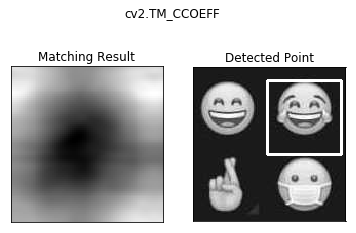

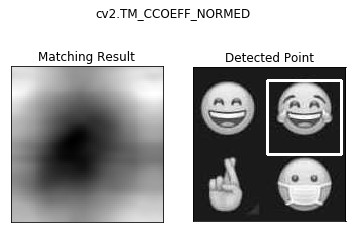

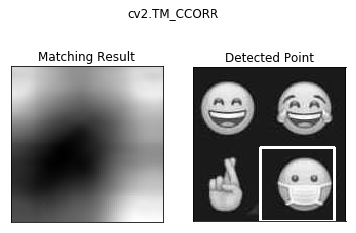

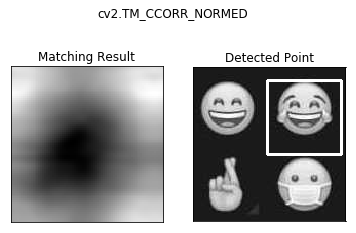

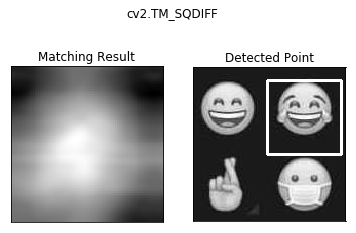

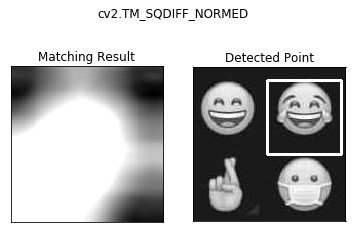

In [88]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

img = cv2.imread('whatsapp_recent/Anirban_2.jpeg',0)
img2 = img.copy()
template = cv2.imread('emoji_database/face-with-tears-of-joy_1f602.png',0)
w, h = template.shape[::-1]

# All the 6 methods for comparison in a list
methods = ['cv2.TM_CCOEFF', 'cv2.TM_CCOEFF_NORMED', 'cv2.TM_CCORR',
            'cv2.TM_CCORR_NORMED', 'cv2.TM_SQDIFF', 'cv2.TM_SQDIFF_NORMED']

for meth in methods:
    img = img2.copy()
    method = eval(meth)

    # Apply template Matching
    res = cv2.matchTemplate(img,template,method)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)

    # If the method is TM_SQDIFF or TM_SQDIFF_NORMED, take minimum
    if method in [cv2.TM_SQDIFF, cv2.TM_SQDIFF_NORMED]:
        top_left = min_loc
    else:
        top_left = max_loc
    bottom_right = (top_left[0] + w, top_left[1] + h)

    cv2.rectangle(img,top_left, bottom_right, 255, 2)

    plt.subplot(121),plt.imshow(res,cmap = 'gray')
    plt.title('Matching Result'), plt.xticks([]), plt.yticks([])
    plt.subplot(122),plt.imshow(img,cmap = 'gray')
    plt.title('Detected Point'), plt.xticks([]), plt.yticks([])
    plt.suptitle(meth)

    plt.show()

In [50]:
res.shape

(746, 1005)

In [38]:
from PIL import Image
from matplotlib import pyplot

In [43]:
cv2.imshow(res, map = 'gray')

TypeError: Required argument 'mat' (pos 2) not found

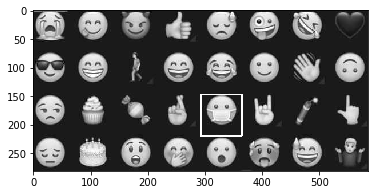

In [72]:
import cv2
import matplotlib.pyplot as plt

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


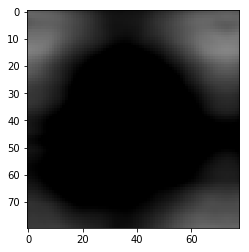

In [95]:
plt.imshow(cv2.cvtColor(res, cv2.COLOR_BGR2RGB))
plt.show()

In [75]:
img

array([[26, 26, 26, ..., 26, 26, 26],
       [26, 26, 26, ..., 26, 26, 26],
       [26, 26, 26, ..., 26, 26, 26],
       ...,
       [26, 26, 26, ..., 26, 26, 26],
       [26, 26, 26, ..., 26, 26, 26],
       [26, 26, 26, ..., 26, 26, 26]], dtype=uint8)

In [86]:
for i in template:
    for j in range(len(i)):
        if i[j]==0:
            i[j]=26
            
        
    

In [87]:
template

array([[26, 26, 26, ..., 26, 26, 26],
       [26, 26, 26, ..., 26, 26, 26],
       [26, 26, 26, ..., 26, 26, 26],
       ...,
       [26, 26, 26, ..., 26, 26, 26],
       [26, 26, 26, ..., 26, 26, 26],
       [26, 26, 26, ..., 26, 26, 26]], dtype=uint8)

In [93]:
min_val, max_val, min_loc, max_loc

(0.49173372983932495, 1.0, (72, 14), (33, 18))

In [94]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

img_rgb = cv2.imread('whatsapp_recent/Anirban_2.jpeg')
img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2GRAY)
template = cv2.imread('emoji_database/face-with-tears-of-joy_1f602.png',0)
w, h = template.shape[::-1]

res = cv2.matchTemplate(img_gray,template,cv2.TM_CCOEFF_NORMED)
threshold = 0.8
loc = np.where( res >= threshold)
for pt in zip(*loc[::-1]):
    cv2.rectangle(img_rgb, pt, (pt[0] + w, pt[1] + h), (0,0,255), 2)

cv2.imwrite('res.png',img_rgb)


True